## 1. 데이터 전처리

In [2]:
import os
import pandas as pd
import numpy as np

base_dir = '데이터 경로' # 특정 데이터 경로 입력
water_dir = base_dir + '/water_data'
rf_dir = base_dir + '/rf_data'
water_list = os.listdir(water_dir)
rf_list = os.listdir(rf_dir)

submission = pd.read_csv(base_dir + '/submission.csv')
submission['ymdhm'] = pd.to_datetime(submission['ymdhm'])
submission.set_index(keys=['ymdhm'], inplace=True)

water = []
for i in range(len(water_list)):
    file_dir = water_dir + '/' + water_list[i]
    df = pd.read_csv(file_dir)
    water.append(df)

water = pd.concat(water, axis = 0)
    
rf = []
for i in range(len(rf_list)):
    file_dir = rf_dir + '/' + rf_list[i]
    df = pd.read_csv(file_dir)
    rf.append(df)
    
rf = pd.concat(rf, axis = 0)

df = pd.merge(water, rf)
df['ymdhm'] = pd.to_datetime(df['ymdhm'])
df.set_index(keys=['ymdhm'], inplace=True)

cutoff = '2022-06-01'
df.loc[cutoff:, submission.columns] = submission[submission.columns]
submission.reset_index(inplace=True)
submission['ymdhm']=submission['ymdhm'].dt.strftime('%Y-%m-%d %H:%M')
df.reset_index(inplace=True)
df['ymdhm']=df['ymdhm'].dt.strftime('%Y-%m-%d %H:%M')

df = df.replace(' ', np.NaN)
df['ymdhm'] = pd.to_datetime(df['ymdhm'])
df.set_index('ymdhm',inplace=True)
df = df.astype('float')

df.reset_index(inplace=True)

result = submission.copy()

## 2. 시각화(히스토그램)

C:\Users\mok\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\mok\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


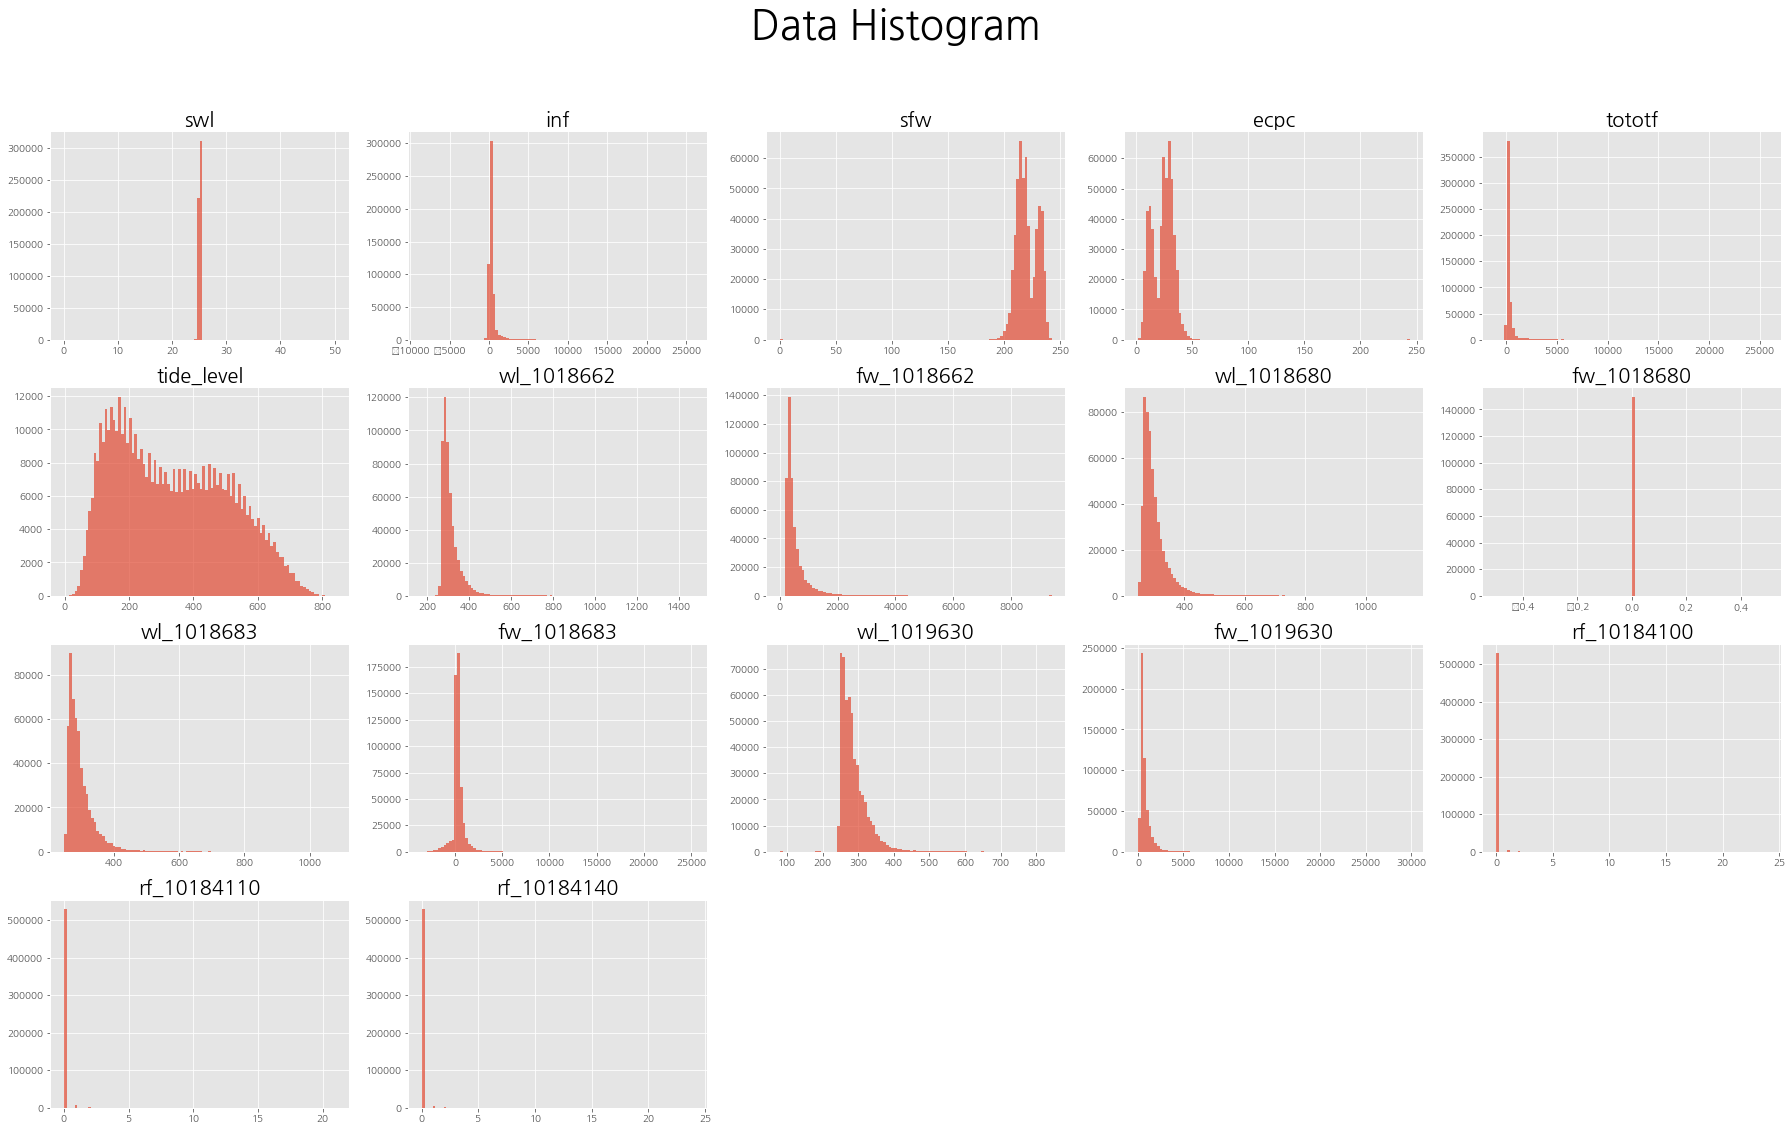

In [3]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.figure(figsize=(25, 20))
plt.suptitle("Data Histogram", fontsize = 40)

cols = df.drop(columns='ymdhm').columns
for i in range(len(cols)):
    plt.subplot(5, 5, i+1)
    plt.title(cols[i], fontsize=20)
    plt.hist(df[cols[i]], bins=100, alpha=0.7)

        
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 3. data, target 분리하기

In [2]:
target = df.loc[:,submission.columns]
target.rename(columns={'wl_1018662':'target1','wl_1018680':'target2',
                       'wl_1018683':'target3','wl_1019630':'target4'},inplace=True)
data = df.drop(submission.columns,axis=1)
data.index += 1

df = pd.concat((data, target), axis = 1)
df = df.iloc[1:-1]
df.reset_index(inplace=True, drop=True)

## 4. 모델링

In [6]:
import lightgbm as lgb

tmp = ['ymdhm','target1','target2','target3','target4']
data = df.drop(tmp,axis=1)
train_data=data.iloc[:-len(submission),:].iloc[:-160000,:]
valid_data=train_data.iloc[-160000:,:]
test_data=data.iloc[-len(submission):,:]

for i in range(len(tmp)-1):
    target = df.loc[:,[tmp[i+1]]]
    
    train_target=target.iloc[:-len(submission),:].iloc[:-160000,:]
    valid_target=train_target.iloc[-160000:,:]

    train_ds = lgb.Dataset(train_data, label = train_target)
    valid_ds = lgb.Dataset(valid_data, label = valid_target)

    params = {'learning_rate': 0.01, 
              'max_depth': -1,
              'boosting': 'gbdt', 
              'metric': 'rmse',
              'objective': 'regression',
              'is_training_metric' : True,
              'num_leaves': 200,
              'feature_fraction': 0.9,
              'bagging_fraction': 0.7,
              'bagging_freq': 5,
              'seed': 2022}

    model = lgb.train(params, train_ds, 10000, valid_ds, verbose_eval = 1000, early_stopping_rounds = 100)
    y_pred=model.predict(test_data)
    
    submission.iloc[:,i+1:i+2] = y_pred

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 370063, number of used features: 13
[LightGBM] [Info] Start training from score 314.795157
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 25.868
[200]	valid_0's rmse: 13.0332
[300]	valid_0's rmse: 8.87482
[400]	valid_0's rmse: 7.4426
[500]	valid_0's rmse: 6.73537
[600]	valid_0's rmse: 6.22981
[700]	valid_0's rmse: 5.81068
[800]	valid_0's rmse: 5.4742
[900]	valid_0's rmse: 5.18688
[1000]	valid_0's rmse: 4.91736
[1100]	valid_0's rmse: 4.70774
[1200]	valid_0's rmse: 4.50996
[1300]	valid_0's rmse: 4.36227
[1400]	valid_0's rmse: 4.20889
[1500]	valid_0's rmse: 4.0853
[1600]	valid_0's rmse: 3.95944
[1700]	valid_0's rmse: 3.83128
[1800]	valid

## 5. 정확도 확인

In [7]:
def RMSE(y, pred):
    return np.sqrt(np.mean(np.square(y-pred)))

rmse = RMSE(result.iloc[:,1:5],submission.iloc[:,1:5])
print(rmse)
print(sum(rmse)/len(rmse))

In [8]:
## 6. 제출용 csv 

wl_1018662    11.440495
wl_1018680    10.510809
wl_1018683     6.474137
wl_1019630     2.271390
dtype: float64
7.6742076555099645


In [2]:
submission.to_csv('.../submission.csv', index=False) # 특정 데이터 경로 입력